## Data Analysis
----
In this interactive notebook we will handle more of the automated process that we started in the first data analysis notebook. In particular, we want to automate the process of plotting, checking stationarity, and model fitting for all 51 selected states/locations. Let's start by importing our required libraries and setting some plotting parameters.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

warnings.filterwarnings('ignore')

# plotting settings
%matplotlib inline
register_matplotlib_converters()
plt.rcParams['figure.constrained_layout.use'] = True
sns.set()
sns.set_context('poster')

Let's also read in our needed dataframes from the [`cleaned_data`](./cleaned_data/) folder. We in particular want the dataframes that contains our parameter descriptions as well as our main cleaned and aggregated dataframe.

In [2]:
aqi_gasses = pd.read_csv('cleaned_data/aqi_gasses.csv')
aqi_gasses

,code,parameter_description,param_shorthand,legend_entry
0,42101,Carbon monoxide,CO,42101 - CO
1,42401,Sulfur dioxide,SO2,42401 - SO2
2,42602,Nitrogen dioxide (NO2),NO2,42602 - NO2
3,44201,Ozone,Ozone,44201 - Ozone


In [3]:
main_df = pd.read_csv('cleaned_data/criteria_gasses_aqi_means.csv')
main_df.head()

,state_name,parameter_code,date_local,arithmetic_mean,aqi
0,Alabama,42101,2010-01-01,0.280702,3.333333
1,Alabama,42101,2010-01-02,0.288889,3.333333
2,Alabama,42101,2010-01-03,0.277778,3.333333
3,Alabama,42101,2010-01-04,0.361111,5.333333
4,Alabama,42101,2010-01-05,0.404166,5.333333


Let's make sure that our date column is appropriately cast for our time-series analysis process. This is important for almost all of the operations that we will do with this data.

In [4]:
main_df.date_local = pd.to_datetime(main_df.date_local)
main_df.head()

,state_name,parameter_code,date_local,arithmetic_mean,aqi
0,Alabama,42101,2010-01-01,0.280702,3.333333
1,Alabama,42101,2010-01-02,0.288889,3.333333
2,Alabama,42101,2010-01-03,0.277778,3.333333
3,Alabama,42101,2010-01-04,0.361111,5.333333
4,Alabama,42101,2010-01-05,0.404166,5.333333


In [5]:
main_df.dtypes

state_name                 object
parameter_code              int64
date_local         datetime64[ns]
arithmetic_mean           float64
aqi                       float64
dtype: object

Let's also ensure that our data contains only those locations for which the data is of high integrity. These areas do not include some extra locations in the EPA database, such as Mexico or the Virgin Islands.

In [6]:
len(main_df.state_name.unique())

51

In [7]:
def plot_state_aqi(state_name):
    subset = main_df.loc[main_df.state_name == state_name]
    aqi_fig, aqi_ax = plt.subplots(figsize=(18,12))
    sns.lineplot(
        x='date_local',
        y='aqi',
        hue='parameter_code',
        data=subset,
        ax=aqi_ax,
        legend='full')
    
    # set some plotting variables
    aqi_ax.set_title(f'Mean Daily AQI - {state_name}')
    aqi_ax.set_xlabel('Date')
    aqi_ax.set_ylabel('Mean Air Quality Index')
    aqi_leg = aqi_ax.get_legend()
    aqi_leg.texts[0].set_text('Parameter')
    for l in aqi_leg.texts[1:]:
        index = l.get_text()
        new_label = aqi_gasses.loc[aqi_gasses.code == int(index)].legend_entry.values[0]
        l.set_text(new_label)
        
    aqi_fig.savefig(f'plots/aqi/{state_name}_daily_means.png')
    plt.close(aqi_fig)

In [8]:
for state in main_df.state_name.unique():
    plot_state_aqi(state)

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


## The Dickey-Fuller test
----
In this section we handle checking to see if the data is stationary for each of our states and each of our parameters. This is an important test to determine the degree of differencing that we need in our later SARIMAX modeling. Let's start by getting the required modules from the statsmodels library.

In [9]:
from statsmodels.tsa.stattools import adfuller

Now, we can write a simple function to compute the needed results from the Dickey Fuller test on each state, and wrap these to an easily readable or mutable dataframe object.

In [10]:
def compute_state_adfuller(state_name):
    subset = main_df.loc[main_df.state_name == state_name]
    p_row_to_add = {}
    nlags_row_to_add = {}
    test_stat_row_to_add = {}
    for param in subset.parameter_code.unique():
        param_aqi = subset.loc[subset.parameter_code == param].set_index('date_local').aqi
        param_ad_fuller_results = adfuller(param_aqi, autolag='AIC')
        test_stat_row_to_add[param] = param_ad_fuller_results[0]
        p_row_to_add[param] = param_ad_fuller_results[1]
        nlags_row_to_add[param] = param_ad_fuller_results[2]
        
        
    results_df = pd.DataFrame(
        [test_stat_row_to_add, p_row_to_add, nlags_row_to_add],
        index=['test_stat', 'p_value', 'n_lags'])
    results_df.columns.name = 'parameter_code'
    results_df = results_df.T
    
    results_df['state_name'] = state_name
    results_df = results_df.set_index(['state_name', results_df.index])
    return results_df

We can now use our function to try computing the results for all 50 states.

In [11]:
ad_fuller_results = pd.DataFrame()
for state_name in main_df.state_name.unique():
    ad_fuller_results = pd.concat([ad_fuller_results, compute_state_adfuller(state_name)])

In [12]:
ad_fuller_results.to_csv('results_data/all_states_adfuller_results.csv')
ad_fuller_results

test_stat       p_value  n_lags
state_name parameter_code                                 
Alabama    42101           -7.241769  1.876271e-10    24.0
           42401           -8.763683  2.632414e-14    19.0
           42602           -8.089396  1.391403e-12    12.0
           44201           -5.813361  4.349187e-07    28.0
Alaska     42101           -4.137881  8.379302e-04    26.0
...                              ...           ...     ...
Wisconsin  44201           -4.428923  2.637352e-04    29.0
Wyoming    42101           -4.471009  2.217691e-04    29.0
           42401          -10.662456  4.371776e-19    10.0
           42602           -5.188499  9.280095e-06    27.0
           44201           -4.157624  7.765998e-04    22.0

[202 rows x 3 columns]

Let's check to see how many of our datasets are in fact stationary by the Dickey Fuller test. We can accomplish this easily by filtering along the `p_value` column, and then taking the sum.

In [13]:
ad_fuller_results.p_value < 0.05

state_name  parameter_code
Alabama     42101             True
            42401             True
            42602             True
            44201             True
Alaska      42101             True
                              ... 
Wisconsin   44201             True
Wyoming     42101             True
            42401             True
            42602             True
            44201             True
Name: p_value, Length: 202, dtype: bool

In [14]:
sum(ad_fuller_results.p_value < 0.05)

199

This is not quite all of the rows, but it's very close. Let's figure out which entries seem to have nonstationary data.

In [15]:
ad_fuller_results.loc[ad_fuller_results.p_value >= 0.05]

,,test_stat,p_value,n_lags
state_name,parameter_code,,,
Illinois,42101,-2.853529,0.051025,24.0
Ohio,42401,-2.549789,0.103825,25.0
Utah,42401,-2.319908,0.165627,27.0


Classic Illinois...

## SARIMAX Fitting
----
In this section, we aim to fit a SARIMAX model to our states and parameters, so that we can make some predictions for the year 2019. Let's start by writing a function that will fit SARIMAX models for a given state by name.

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

In [45]:
def compute_aqi_pred_mse(aqi_series, fitted_model):
    model_pred = fitted_model.predict()
    mse = mean_squared_error(aqi_series, model_pred)
    return mse

def compute_aqi_pred_r2(aqi_series, fitted_model):
    model_pred = fitted_model.predict()
    r2 = r2_score(aqi_series, model_pred)
    return r2

def fit_state_monthly_sarimax(state_name, order=(1,0,2), seasonal_order=(0,1,1,12)):
    subset = main_df.loc[main_df.state_name == state_name]
    aic_row = {}
    bic_row = {}
    mse_row = {}
    r2_row = {}
    fitted_models = {}
    for param in subset.parameter_code.unique():
        param_subset = subset.loc[subset.parameter_code == param]
        param_subset_monthly_resample = param_subset.set_index('date_local').resample('MS').mean()
        mod = sm.tsa.statespace.SARIMAX(
            param_subset_monthly_resample.aqi,
            trend='n',
            order=order,
            seasonal_order=seasonal_order)
        starting_params = mod.fit(return_params=True)
        results = mod.fit(start_params=starting_params)
        aic_row[param] = results.aic
        bic_row[param] = results.bic
        try:
            mse = compute_aqi_pred_mse(param_subset_monthly_resample.aqi, results)
            mse_row[param] = mse
        except ValueError:
            mse = np.nan
            mse_row[param] = mse
        try:
            r2 = compute_aqi_pred_r2(param_subset_monthly_resample.aqi, results)
            r2_row[param] = r2
        except ValueError:
            r2 = np.nan
            r2_row[param] = r2
        fitted_models[(state_name, param)] = results
    
    results_df = pd.DataFrame([aic_row, bic_row, mse_row, r2_row], index=['aic', 'bic', 'mse', 'r2'])
    results_df.columns.name = 'parameter_code'
    results_df = results_df.T
    results_df['state_name'] = state_name
    results_df.set_index(['state_name', results_df.index], inplace=True)
    return results_df, fitted_models

Now that we have this function which can both get the important results as a Pandas dataframe as well as store the fitted models in a dictionary object indexed by tuples representing (state, parameter) combinations, we can loop over all the possible states to find all relevant AIC and BIC results for monthly models, as well as store the full set of fitted models in a Python dictionary for easy future prediction.

In [46]:
all_state_monthly_sarimax_results = pd.DataFrame()
all_state_monthly_models = {}

for state_name in main_df.state_name.unique():
    new_results, new_models = fit_state_monthly_sarimax(state_name)
    all_state_monthly_sarimax_results = pd.concat(
        [all_state_monthly_sarimax_results, new_results])
    all_state_monthly_models.update(new_models)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statesp

Let's save our results in the appropriate folder.

In [47]:
all_state_monthly_sarimax_results.to_csv('results_data/monthly_sarimax_model_metrics.csv')
all_state_monthly_sarimax_results

aic         bic         mse        r2
state_name parameter_code                                              
Alabama    42101           271.466787  284.288528    5.480198 -3.308359
           42401           454.141513  466.963254   14.004282 -1.164902
           42602           271.411766  280.870867  121.572413 -8.639088
           44201           608.694265  621.516006  214.019232 -2.209424
Alaska     42101           490.219992  503.041732         NaN       NaN
...                               ...         ...         ...       ...
Wisconsin  44201           562.511551  575.333292  175.361061 -1.504220
Wyoming    42101           185.317608  198.139349    1.040968 -0.617383
           42401           414.537970  427.359711   11.031010 -1.130529
           42602           266.035482  278.857223    6.385565 -2.003009
           44201           472.531349  485.353090  229.747950 -4.201449

[202 rows x 4 columns]

In [48]:
def plot_predictions(true_results, predictions, figsize=(18, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(true_results, marker='o', linestyle='None')
    sns.lineplot(data=predictions, ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Air Quality Index')
    ax.legend(['True Values', 'Model Predictions'])
    return fig, ax

In [49]:
def plot_state_monthly_predictions(state_name, figsize=(18, 12)):
    subset = main_df.loc[main_df.state_name == state_name]
    for param in subset.parameter_code.unique():
        param_subset = subset.loc[subset.parameter_code == param]
        param_subset_monthly_resample = param_subset.set_index('date_local').resample('MS').mean()
        fitted_model = all_state_monthly_models[(state_name, param)]
        pred = fitted_model.predict()
        p_fig, p_ax = plot_predictions(param_subset_monthly_resample.aqi, pred)
        legend_entry = aqi_gasses.loc[aqi_gasses.code == param].legend_entry.values[0]
        p_ax.set_title(f'True Results vs Model Predicted Values - {legend_entry} in {state_name}')
        p_fig.savefig(f'plots/predict/{state_name}_{param}_predicted.png')
        plt.close(p_fig)

In [50]:
for state in main_df.state_name.unique():
    plot_state_monthly_predictions(state, figsize=(18, 10))

To make the process of plotting these statistical results slightly easier, we will reset the index so that we can easily group or pass into Seaborn arguments.

In [23]:
monthly_sarimax_results_for_plotting = all_state_monthly_sarimax_results.reset_index()

In [24]:
monthly_sarimax_results_for_plotting.head()

,state_name,parameter_code,aic,bic,mse,r2
0,Alabama,42101,271.466787,284.288528,5.480198,-3.308359
1,Alabama,42401,454.141513,466.963254,14.004282,-1.164902
2,Alabama,42602,271.411766,280.870867,121.572392,-8.639086
3,Alabama,44201,608.694265,621.516006,214.019232,-2.209424
4,Alaska,42101,490.219992,503.041732,NaN,NaN


We want a visual representation of the distributions of these AIC and BIC results. Luckily, a violinplot offers a great method that can also include additional depictions of spread over all 51 locations.

In [37]:
def sarimax_violin_plot(sarimax_results, metric='bic', figsize=(18,12)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.violinplot(x='parameter_code', y=metric, data=sarimax_results.dropna(subset=[metric]), inner='quart', ax=ax)
    ax.set_title(f'Distributions of {metric.upper()} by Parameter')
    ax.set_ylabel(f'{metric.upper()}')
    ax.set_xlabel('Parameter')
    old_labels = ax.get_xticklabels()
    new_labels = []
    for ol in old_labels:
        index = int(ol.get_text())
        new_label = aqi_gasses.loc[aqi_gasses.code == index, 'legend_entry'].values[0]
        new_labels.append(new_label)
    ax.set_xticklabels(new_labels)
    return fig, ax

Now, let's use our funtion above to create and save some figures of the distributions of each parameter over all 51 locations.

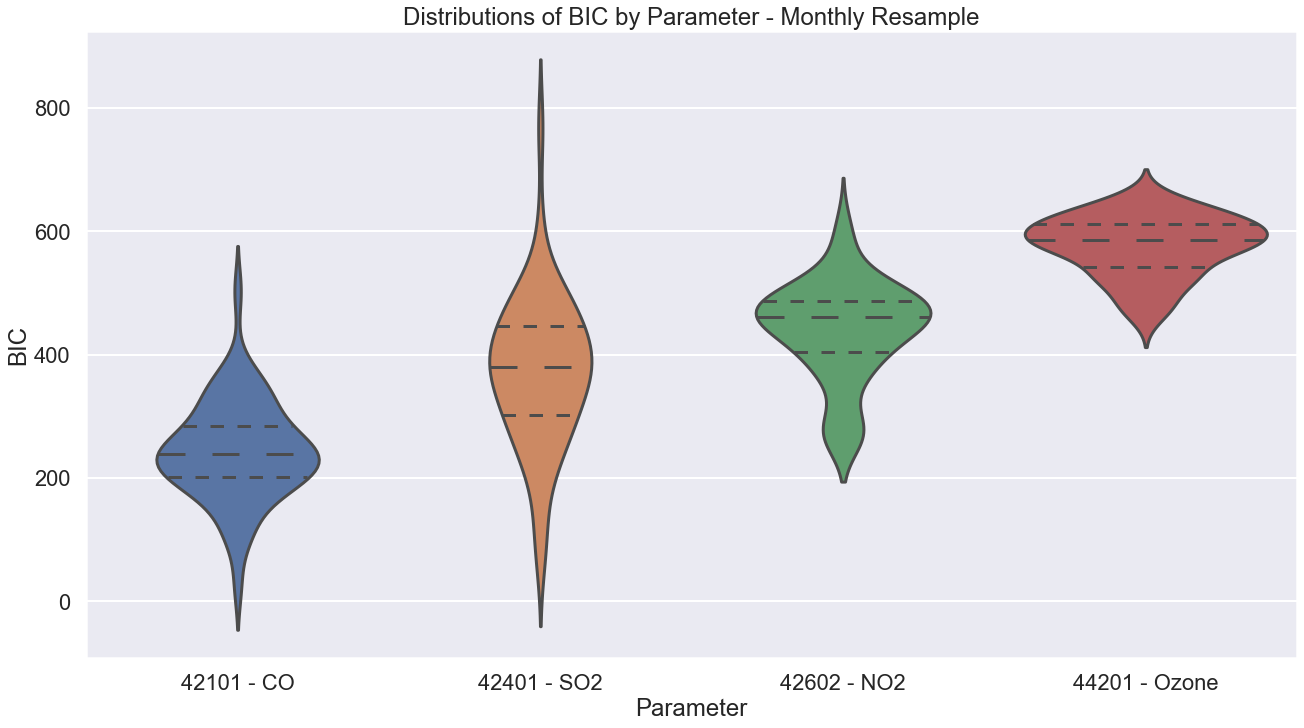

In [38]:
monthly_violin_fig, monthly_violin_ax = sarimax_violin_plot(monthly_sarimax_results_for_plotting, figsize=(18,10))
monthly_violin_ax.set_title(monthly_violin_ax.title.get_text() + ' - Monthly Resample')
monthly_violin_fig.savefig('plots/monthly_sarimax_bic_distribution_by_param.png')

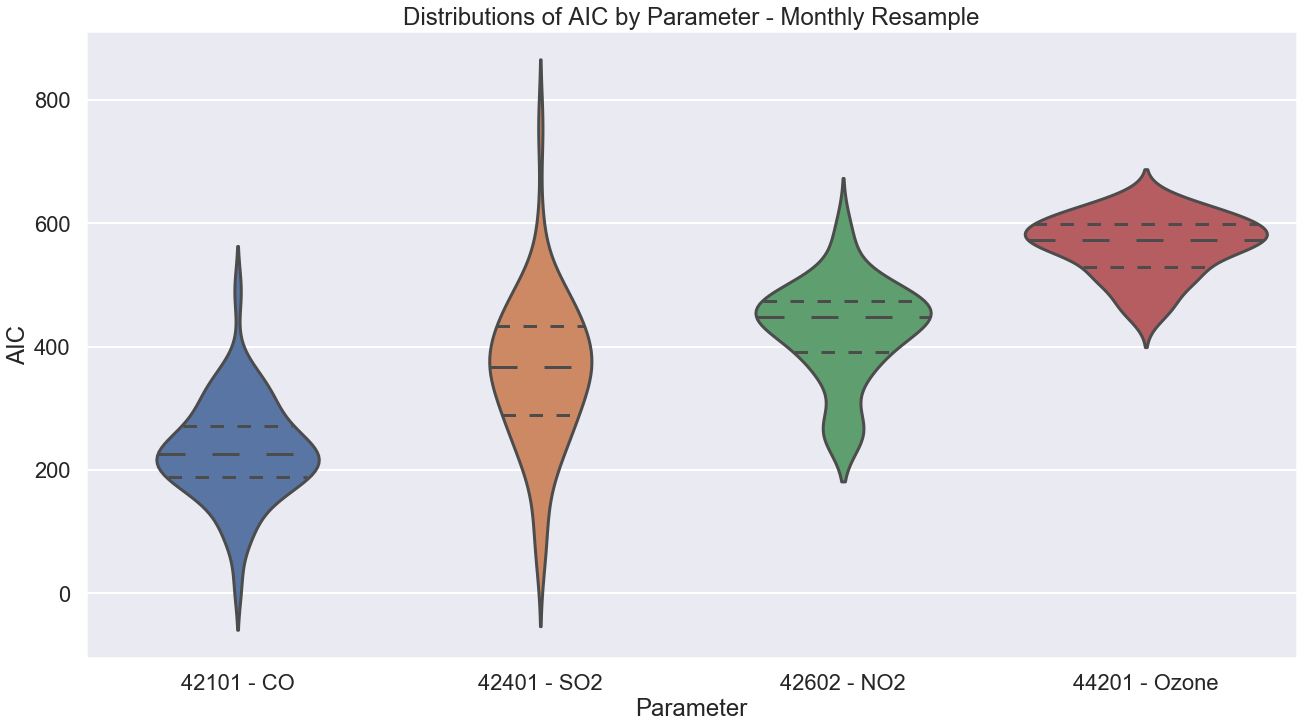

In [39]:
monthly_violin_fig, monthly_violin_ax = sarimax_violin_plot(monthly_sarimax_results_for_plotting, metric='aic', figsize=(18,10))
monthly_violin_ax.set_title(monthly_violin_ax.title.get_text() + ' - Monthly Resample')
monthly_violin_fig.savefig('plots/monthly_sarimax_aic_distribution_by_param.png')

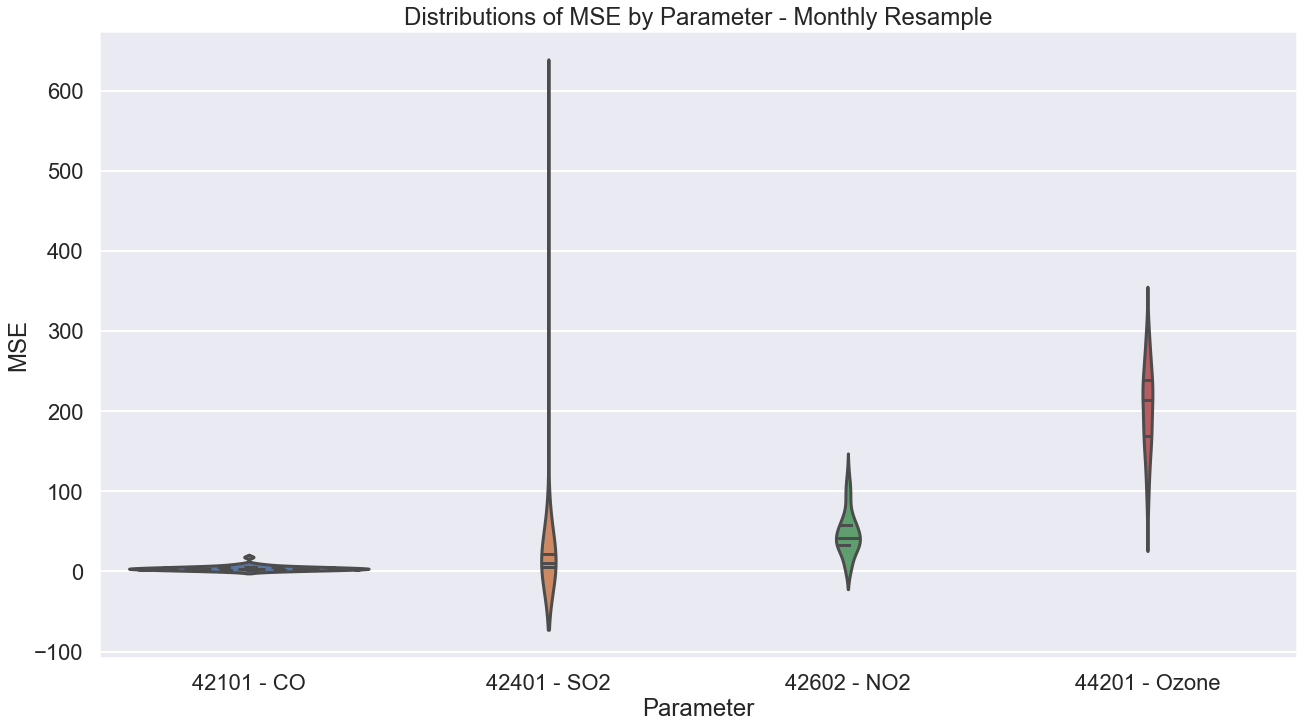

In [40]:
monthly_violin_fig, monthly_violin_ax = sarimax_violin_plot(monthly_sarimax_results_for_plotting, metric='mse', figsize=(18, 10))
monthly_violin_ax.set_title(monthly_violin_ax.title.get_text() + ' - Monthly Resample')
monthly_violin_fig.savefig('plots/monthly_sarimax_mse_distribution_by_param.png')

In [41]:
def sarimax_swarmplot(sarimax_results, metric='bic', figsize=(18,12)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.swarmplot(x='parameter_code', y=metric, data=sarimax_results.dropna(subset=[metric]), ax=ax, size=12.0)
    ax.set_title(f'Scatterplot of {metric.upper()} by Parameter')
    ax.set_ylabel(f'{metric.upper()}')
    ax.set_xlabel('Parameter')
    old_labels = ax.get_xticklabels()
    new_labels = []
    for ol in old_labels:
        index = int(ol.get_text())
        new_label = aqi_gasses.loc[aqi_gasses.code == index, 'legend_entry'].values[0]
        new_labels.append(new_label)
    ax.set_xticklabels(new_labels)
    return fig, ax

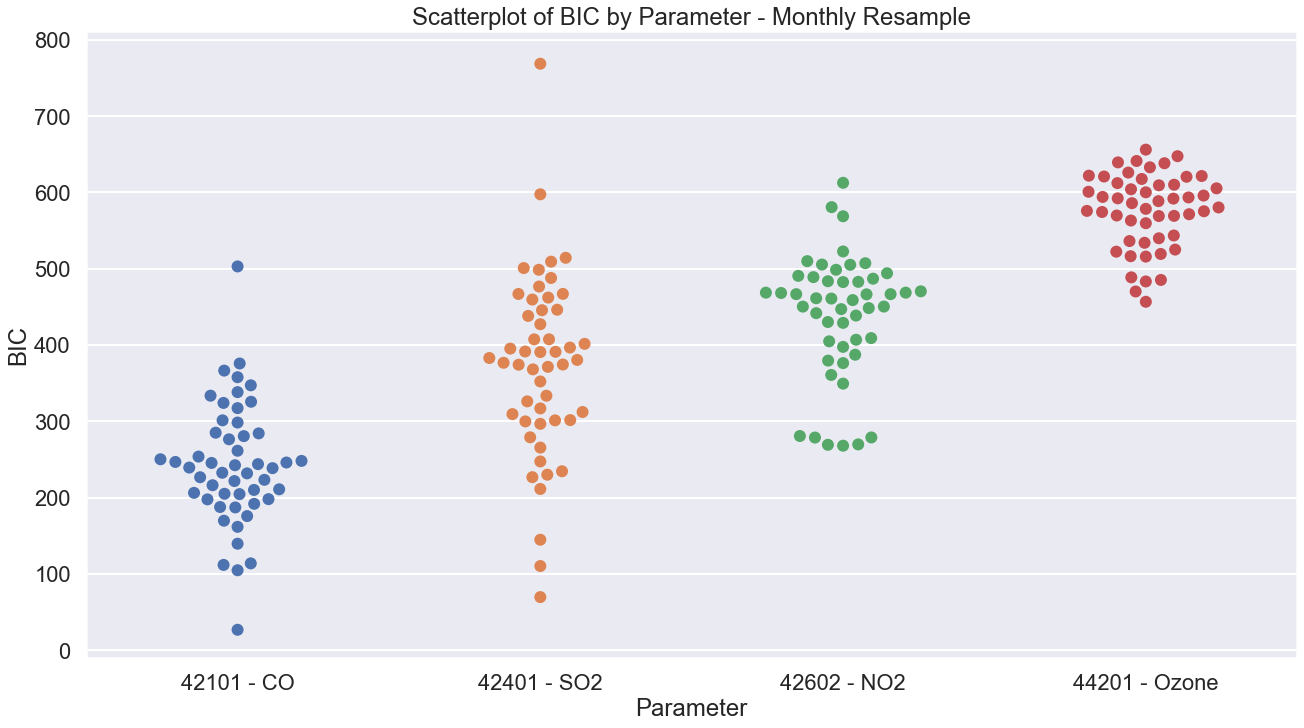

In [42]:
monthly_swarm_fig, monthly_swarm_ax = sarimax_swarmplot(monthly_sarimax_results_for_plotting, figsize=(18,10))
monthly_swarm_ax.set_title(monthly_swarm_ax.title.get_text() + ' - Monthly Resample')
monthly_swarm_fig.savefig('plots/monthly_sarimax_bic_swarm_by_param.png')

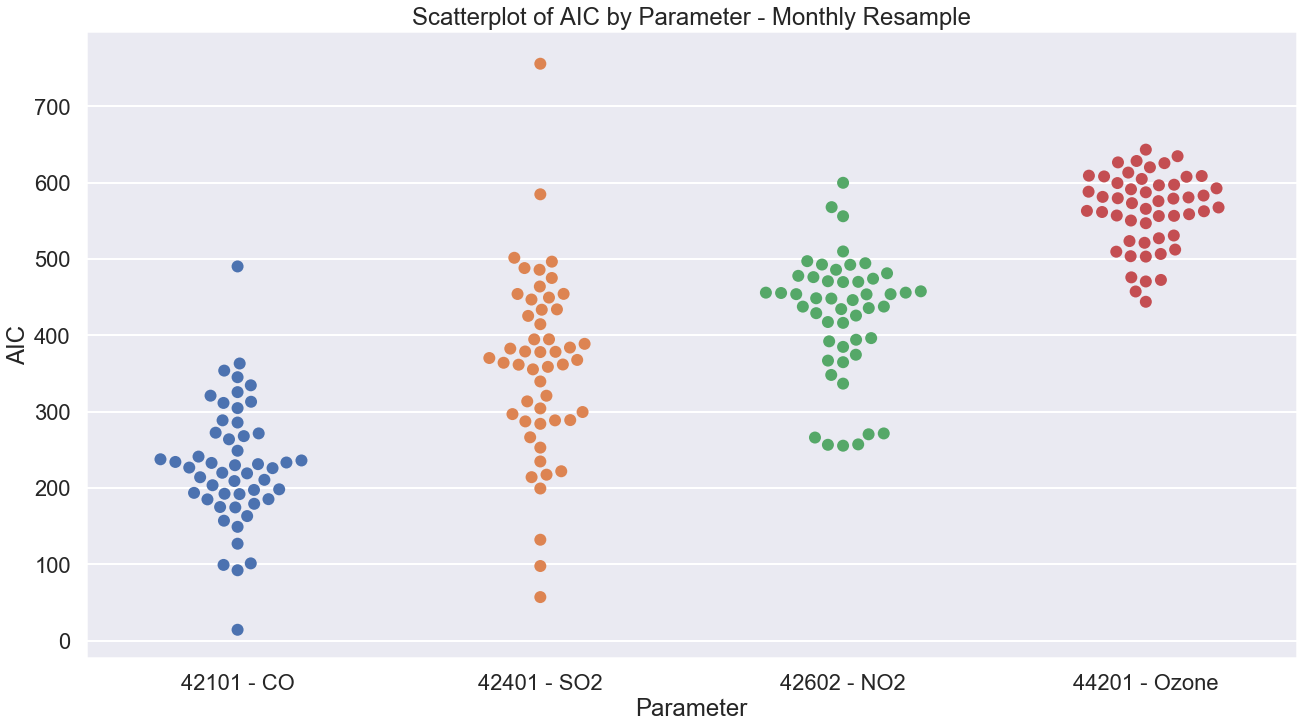

In [43]:
monthly_swarm_fig, monthly_swarm_ax = sarimax_swarmplot(monthly_sarimax_results_for_plotting, metric='aic', figsize=(18,10))
monthly_swarm_ax.set_title(monthly_swarm_ax.title.get_text() + ' - Monthly Resample')
monthly_swarm_fig.savefig('plots/monthly_sarimax_aic_swarm_by_param.png')

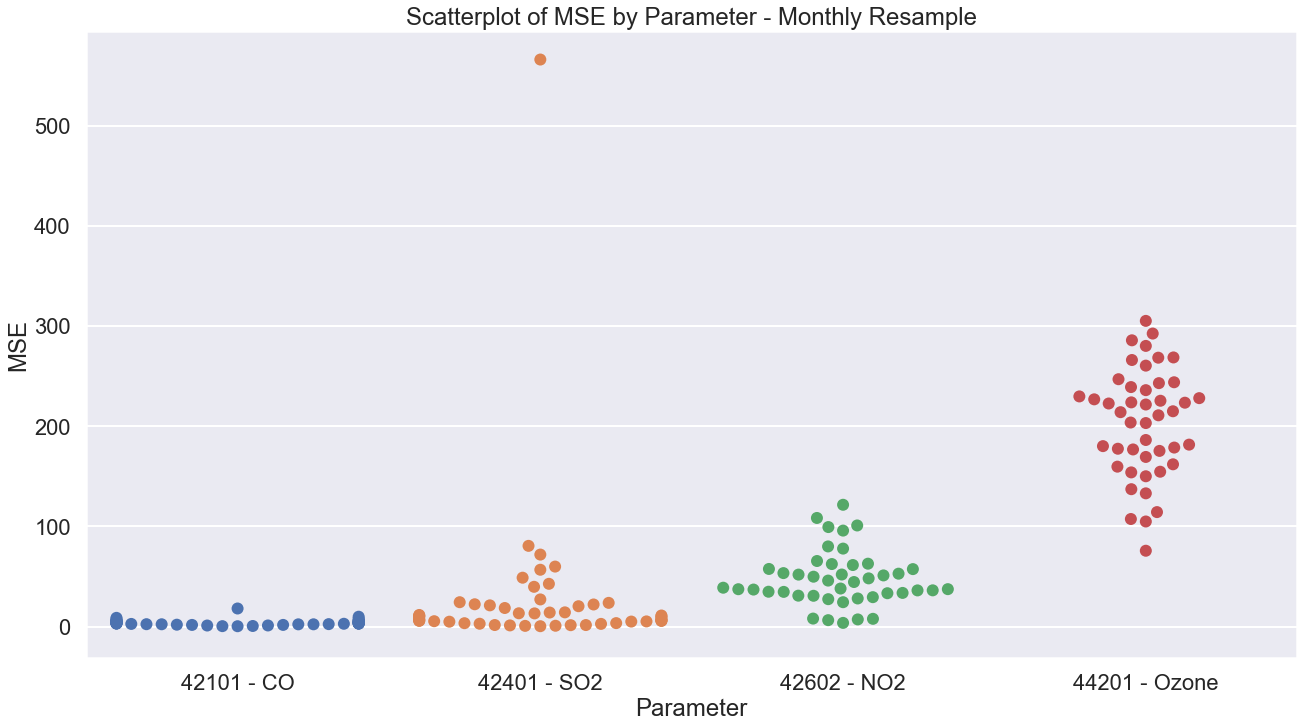

In [44]:
monthly_swarm_fig, monthly_swarm_ax = sarimax_swarmplot(monthly_sarimax_results_for_plotting, metric='mse', figsize=(18,10))
monthly_swarm_ax.set_title(monthly_swarm_ax.title.get_text() + ' - Monthly Resample')
monthly_swarm_fig.savefig('plots/monthly_sarimax_mse_swarm_by_param.png')

## SARIMAX Forecasting
----
Now the we have fitted some models to our observed data, we can try to use these data to forecast into 2019 and beyond.

In [31]:
from dateutil.relativedelta import relativedelta

def forecast_aqi_state_parameter(param_subset, fitted_model, n_months):
    parameter_code = param_subset.parameter_code.unique()[0]
    
    start_index = param_subset.index[-1] + relativedelta(months=1)
    
    new_dates = [start_index+relativedelta(months = i) for i in range(n_months)]
    future = pd.DataFrame(index=new_dates, columns=param_subset.columns)
    future.parameter_code = future.parameter_code.fillna(parameter_code)
    predict_on_df = pd.concat([param_subset, future]).drop(columns=['arithmetic_mean'])
    
    forecasted_aqi = fitted_model.predict(start=start_index, end=new_dates[-1])
    
    return forecasted_aqi
    
    
ca_co = main_df.loc[
    (main_df.state_name == 'California') & (main_df.parameter_code == 42101)].set_index('date_local').resample('MS').mean()
mod = all_state_monthly_models[('California', 42101)]
n_months = 24

ca_forecast_test = forecast_aqi_state_parameter(ca_co, mod, n_months)

In [32]:
def plot_predictions_and_forecasts(true_results, predictions, forecast, figsize=(18, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(true_results, marker='o', linestyle='None')
    sns.lineplot(data=predictions, ax=ax)
    sns.lineplot(data=forecast, ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Air Quality Index')
    ax.legend(['True Values', 'Model Predictions', 'Forecasted Values'])
    return fig, ax

In [33]:
def plot_state_monthly_predictions_and_forecasts(state_name, forecast_months, figsize=(18, 12)):
    subset = main_df.loc[main_df.state_name == state_name]
    for param in subset.parameter_code.unique():
        param_subset = subset.loc[subset.parameter_code == param]
        param_subset_monthly_resample = param_subset.set_index('date_local').resample('MS').mean()
        fitted_model = all_state_monthly_models[(state_name, param)]
        pred = fitted_model.predict()
        forecast = forecast_aqi_state_parameter(param_subset_monthly_resample, fitted_model, forecast_months)
        p_fig, p_ax = plot_predictions_and_forecasts(param_subset_monthly_resample.aqi, pred, forecast)
        legend_entry = aqi_gasses.loc[aqi_gasses.code == param].legend_entry.values[0]
        p_ax.set_title(f'True Results vs Model Predicted and Forecasted Values - {legend_entry} in {state_name}')
        p_fig.savefig(f'plots/forecast/{state_name}_{param}_forecasted.png')
        plt.close(p_fig)

In [34]:
n_months = 36
for state in main_df.state_name.unique():
    plot_state_monthly_predictions_and_forecasts(state, n_months, figsize=(18, 10))